In [1]:
from sklearn.model_selection import train_test_split

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

# Carregando e preparando os dados para os modelos de regressão linear

In [60]:
df_train = pd.read_csv('../../input/clean_data/renner_web_treino.csv')
df_test = pd.read_csv('../../input/renner_desafio_pucrs_teste_1.csv')
df_test, _ = dataPipeline(df_test)

Dataframe carregado!
Colunas 'item' e 'semana_comercial' dropadas!
Vendas Guide Shop (GS) dropadas!
Vendas negativas alteradas para zero!
Variaveis categoricas transformadas em numéricas!
coluna 'data_semana_comercial' transformada em datetime!
Dataset de treino para lojas web criado
Dataset de treino para lojas fisicas criado


In [61]:
df_train = df_train.set_index('data_semana_comercial')
df_train.index = pd.to_datetime(df_train.index)

df_test = df_test.set_index('data_semana_comercial')
df_test.index = pd.to_datetime(df_test.index)

<AxesSubplot: title={'center': 'Vendas lojas web'}, xlabel='data_semana_comercial'>

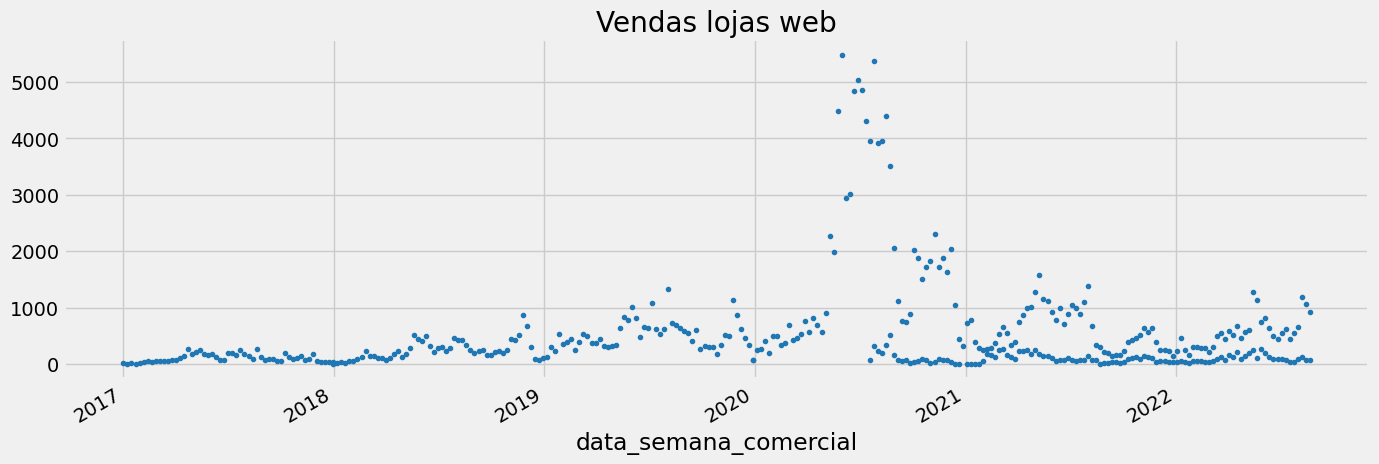

In [24]:
df_train['venda'].plot(style='.',
              figsize=(15,5),
              color=color_pal[0],
              title='Vendas lojas web')

<AxesSubplot: ylabel='Frequency'>

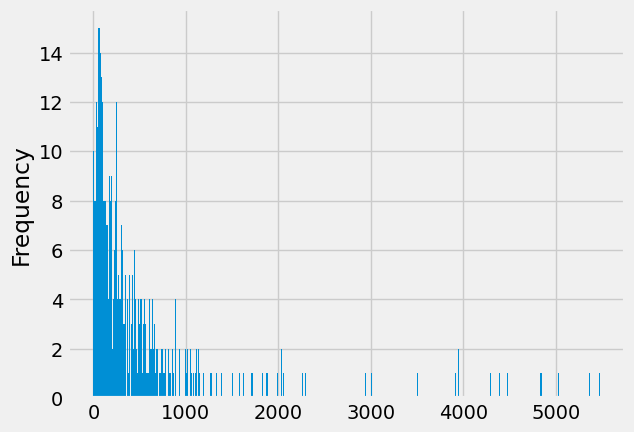

In [25]:
df_train['venda'].plot(kind='hist', bins=500)

In [26]:
loja1 = df_train[df_train['cod_loja'] == 406]
loja2 = df_train[df_train['cod_loja'] == 407]

In [62]:
loja1_test = df_test[df_test['cod_loja'] == 406]
loja2_test = df_test[df_test['cod_loja'] == 407]

<AxesSubplot: title={'center': 'Vendas lojas web 406'}, xlabel='data_semana_comercial'>

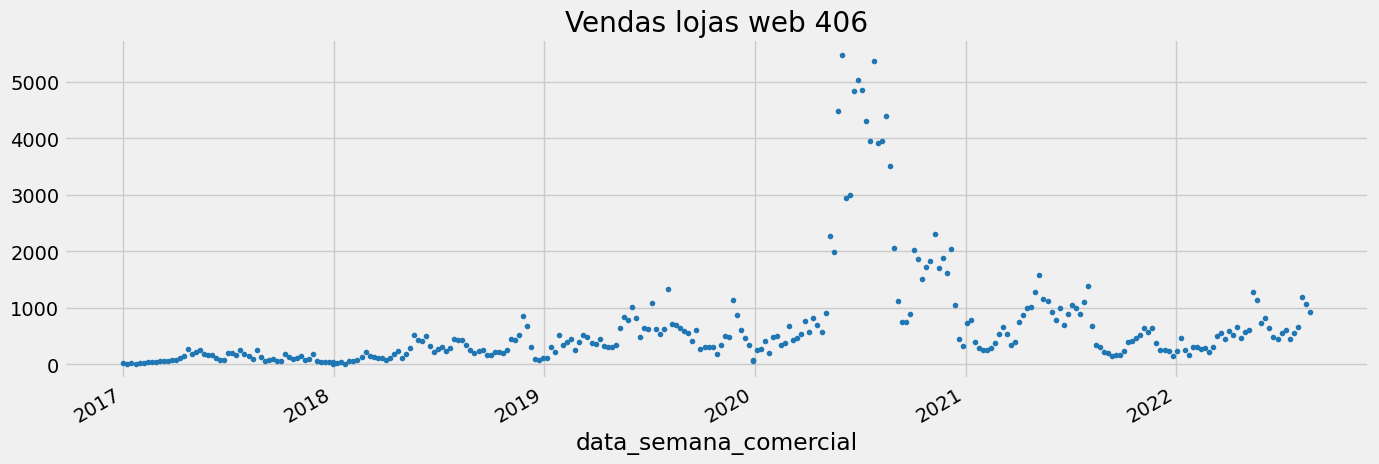

In [27]:
loja1['venda'].plot(style='.',
              figsize=(15,5),
              color=color_pal[0],
              title='Vendas lojas web 406')

<AxesSubplot: ylabel='Frequency'>

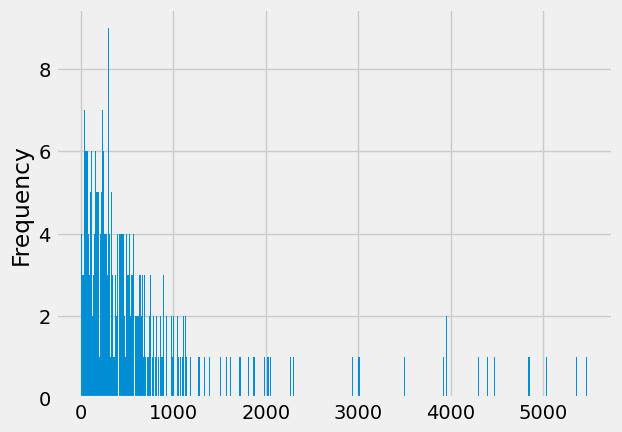

In [29]:
loja1['venda'].plot(kind='hist', bins=500)

<AxesSubplot: title={'center': 'Vendas lojas web 407'}, xlabel='data_semana_comercial'>

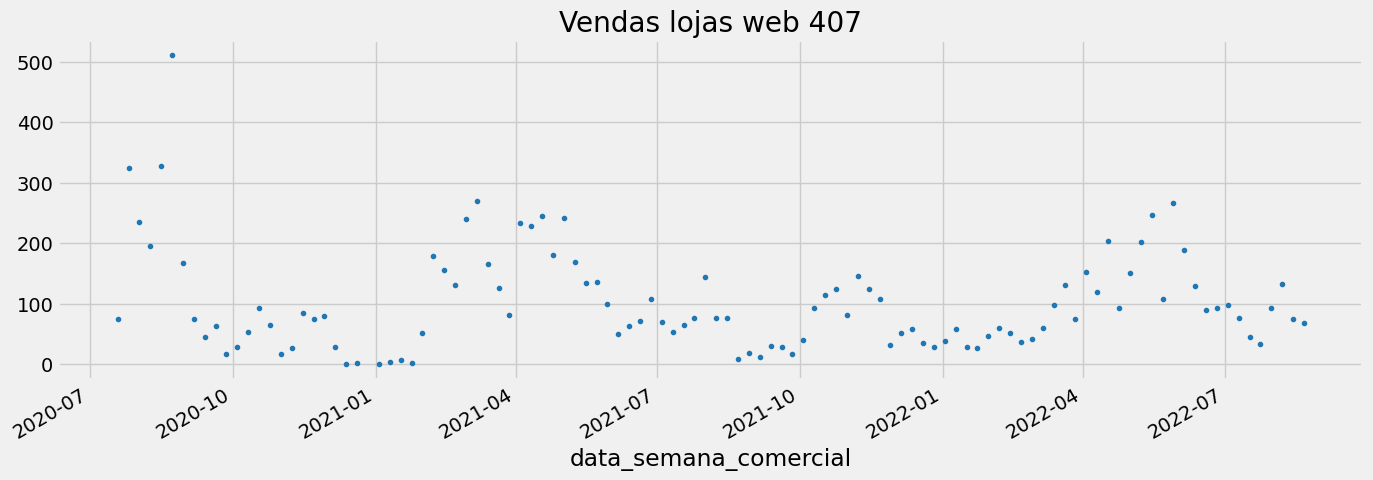

In [16]:
loja2['venda'].plot(style='.',
              figsize=(15,5),
              color=color_pal[0],
              title='Vendas lojas web 407')

<AxesSubplot: ylabel='Frequency'>

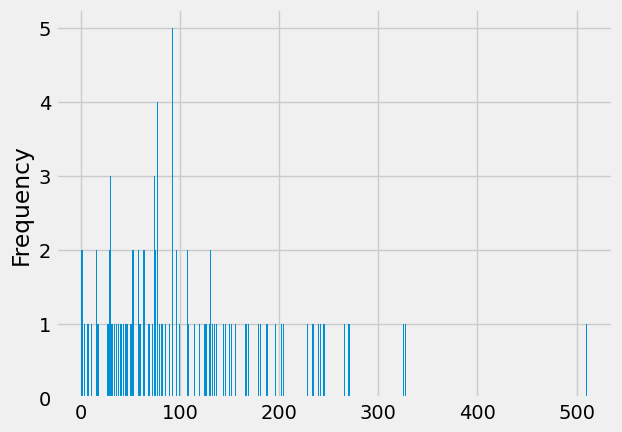

In [17]:
loja2['venda'].plot(kind='hist', bins=500)

In [30]:
loja2 = loja2.query('venda < 300').copy()

In [33]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

loja1 = create_features(loja1)
loja2 = create_features(loja2)

In [42]:
def add_lags(df):
    target_map = df['venda'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    return df

In [43]:
loja1 = add_lags(loja1)
loja2 = add_lags(loja2)

In [45]:
tss = TimeSeriesSplit(n_splits=5)
loja1 = loja1.sort_index()
loja2 = loja2.sort_index()

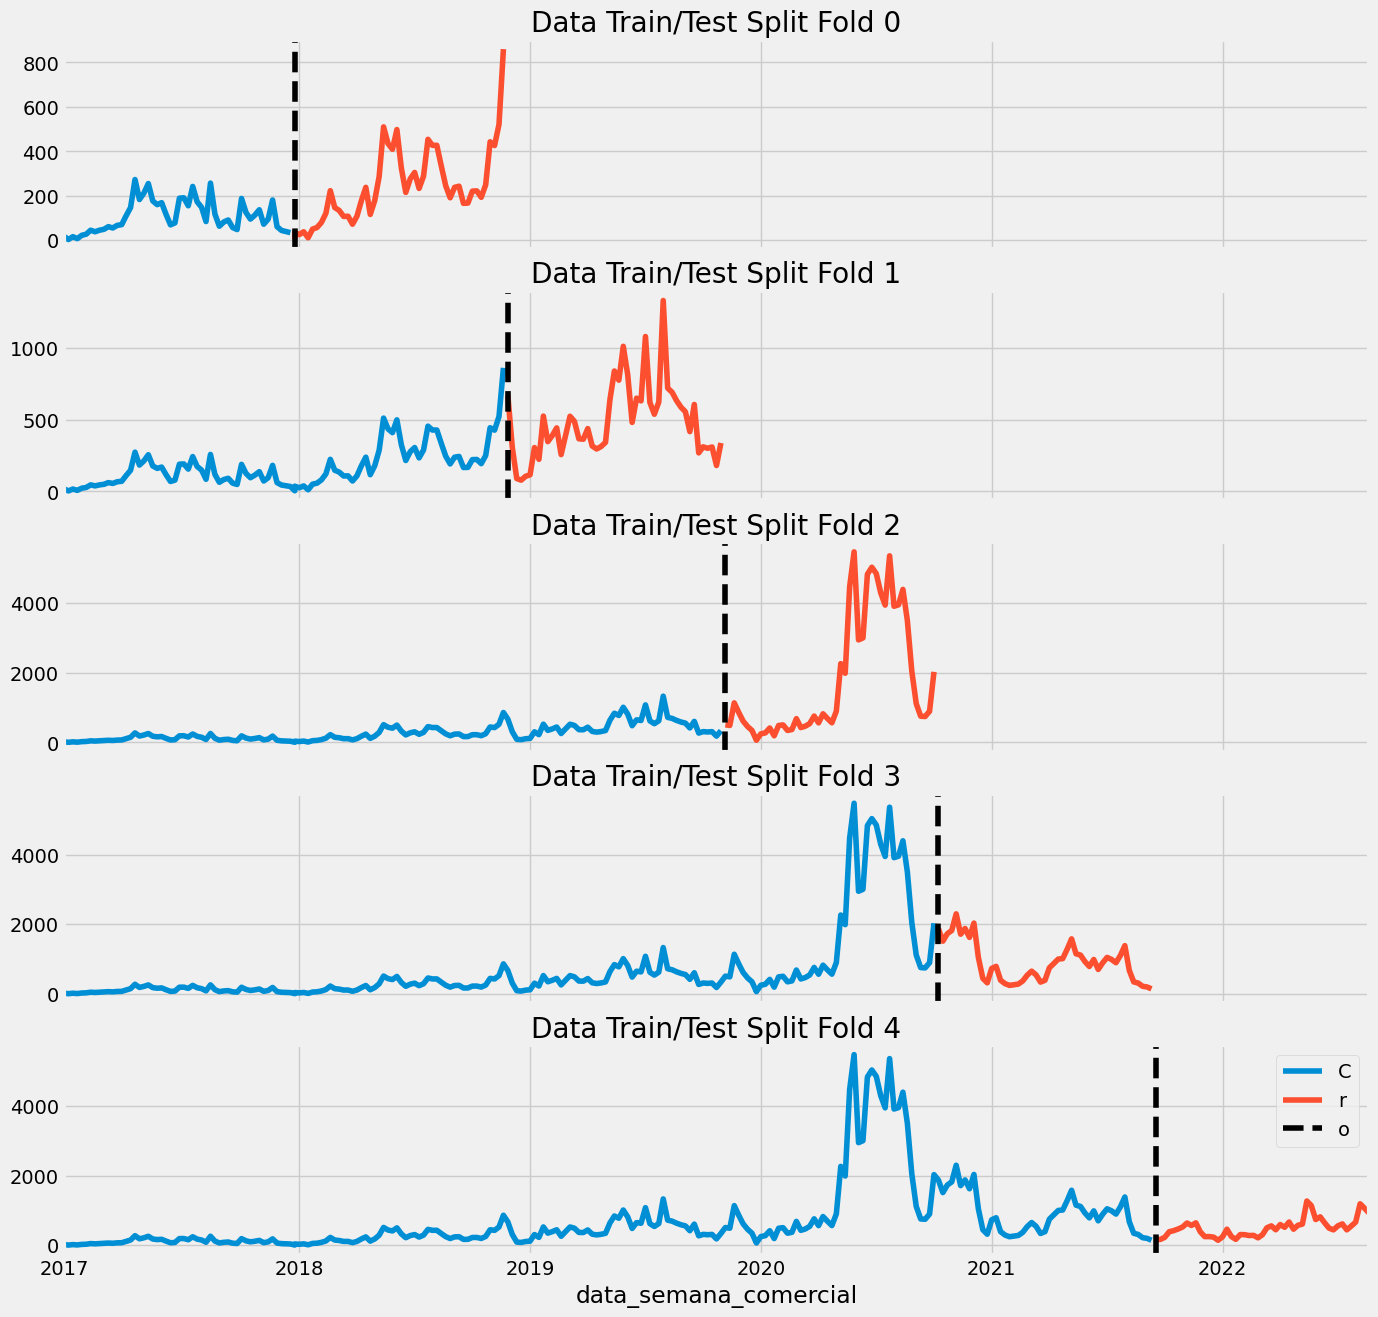

In [46]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(loja1):
    train = loja1.iloc[train_idx]
    test = loja1.iloc[val_idx]
    train['venda'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['venda'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.legend('Cross Validation split para loja 406')
plt.show()

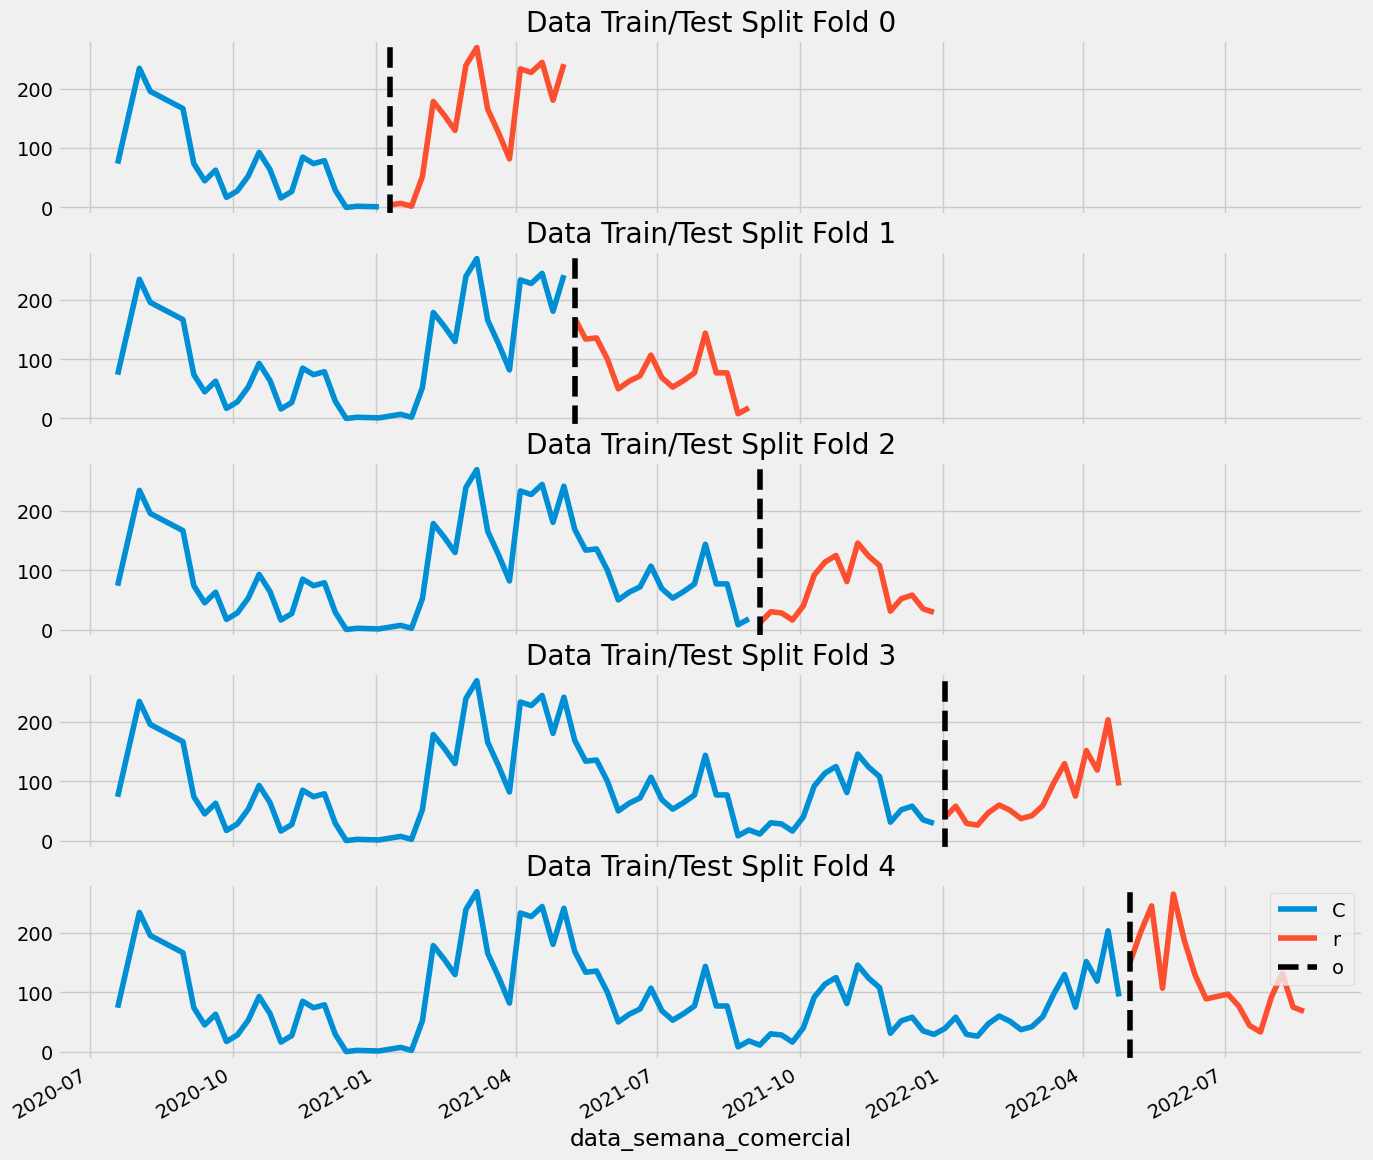

In [48]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(loja2):
    train = loja2.iloc[train_idx]
    test = loja2.iloc[val_idx]
    train['venda'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['venda'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.legend('Cross Validation split para loja 407')
plt.show()

In [69]:

#LOJA1 - 406 - TREINAMENTO
tss = TimeSeriesSplit(n_splits=5)
df = loja1.sort_index()


fold = 0
preds_loja1 = []
scores_loja1 = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'venda'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg_loja1 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg_loja1.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg_loja1.predict(X_test)
    preds_loja1.append(y_pred)
    score = mean_absolute_percentage_error(y_test, y_pred)
    scores_loja1.append(score)

[12:05:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:126.54017	validation_1-rmse:292.42772
[100]	validation_0-rmse:60.53922	validation_1-rmse:223.88704
[200]	validation_0-rmse:37.60264	validation_1-rmse:202.84884
[300]	validation_0-rmse:26.33036	validation_1-rmse:196.15639
[400]	validation_0-rmse:20.12697	validation_1-rmse:193.39780
[500]	validation_0-rmse:16.47795	validation_1-rmse:192.00904
[600]	validation_0-rmse:14.17699	validation_1-rmse:190.67211
[668]	validation_0-rmse:12.59339	validation_1-rmse:191.19468
[12:05:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:222.15225	validation_1-rmse:5

In [70]:
print(f'Score across folds loja1 {np.mean(scores_loja1):0.4f}')
print(f'Fold scores loja1:{scores_loja1}')

Score across folds loja1 0.5041
Fold scores loja1:[0.6065815108459862, 0.5027181905723843, 0.7429724245801429, 0.4244361248568581, 0.2438968546455923]


In [76]:
#LOJA2 - 407 - TREINAMENTO
tss = TimeSeriesSplit(n_splits=5)
df = loja2.sort_index()


fold = 0
preds_loja2 = []
scores_loja2 = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'venda'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg_loja2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg_loja2.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg_loja2.predict(X_test)
    preds_loja2.append(y_pred)
    score = mean_absolute_percentage_error(y_test, y_pred)
    scores_loja2.append(score)

[12:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:90.47307	validation_1-rmse:173.50325
[100]	validation_0-rmse:44.48358	validation_1-rmse:166.12765
[200]	validation_0-rmse:24.11964	validation_1-rmse:161.70518
[300]	validation_0-rmse:14.16995	validation_1-rmse:159.78790
[400]	validation_0-rmse:8.62136	validation_1-rmse:149.44476
[500]	validation_0-rmse:5.35694	validation_1-rmse:145.47659
[600]	validation_0-rmse:3.36930	validation_1-rmse:144.63892
[700]	validation_0-rmse:2.10805	validation_1-rmse:143.80680
[800]	validation_0-rmse:1.31923	validation_1-rmse:143.31017
[900]	validation_0-rmse:0.83358	validation_1-rmse:142.88548
[999]	validation_0-rmse:0.53249	validation_1-rmse:142.77408
[12:08:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1

In [77]:
print(f'Score across folds loja2 {np.mean(scores_loja2):0.4f}')
print(f'Fold scores loja2:{scores_loja2}')

Score across folds loja2 0.5991
Fold scores loja2:[0.9008431233979408, 0.6673658364854383, 0.6080270420491348, 0.499688971917875, 0.3194209178616437]


In [71]:
# Retrain on all data - loja1
df = create_features(loja1)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'venda'

X_all = df[FEATURES]
y_all = df[TARGET]

reg_loja1 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg_loja1.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[12:05:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1128.83847
[100]	validation_0-rmse:498.87828
[200]	validation_0-rmse:277.33875
[300]	validation_0-rmse:201.77580
[400]	validation_0-rmse:174.58492
[499]	validation_0-rmse:157.48855


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [78]:
# Retrain on all data - loja2
df = create_features(loja2)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'venda'

X_all = df[FEATURES]
y_all = df[TARGET]

reg_loja2 = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg_loja2.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[12:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:114.13922
[100]	validation_0-rmse:56.45790
[200]	validation_0-rmse:35.70641
[300]	validation_0-rmse:28.07398
[400]	validation_0-rmse:24.35730
[499]	validation_0-rmse:22.06844


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [66]:
loja1_test = create_features(loja1_test)
loja1_test = add_lags(loja1_test)
loja1_test.head()

,venda,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
data_semana_comercial,,,,,,,,,,,
2022-05-15,1269,6,2,5,2022,135,15,19,605.0,572.0,NaN
2022-05-08,605,6,2,5,2022,128,8,18,572.0,NaN,NaN
2022-05-29,737,6,2,5,2022,149,29,21,1138.0,1269.0,605.0
2022-05-01,572,6,2,5,2022,121,1,17,NaN,NaN,NaN
2022-06-19,489,6,2,6,2022,170,19,24,644.0,814.0,737.0


In [79]:
loja2_test = create_features(loja2_test)
loja2_test = add_lags(loja2_test)
loja2_test.head()

,cod_loja,venda,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
data_semana_comercial,,,,,,,,,,,,
2022-06-05,407,188,6,2,6,2022,156,5,22,266.0,107.0,246.0
2022-06-12,407,129,6,2,6,2022,163,12,23,188.0,266.0,107.0
2022-05-15,407,246,6,2,5,2022,135,15,19,202.0,150.0,NaN
2022-05-01,407,150,6,2,5,2022,121,1,17,NaN,NaN,NaN
2022-05-29,407,266,6,2,5,2022,149,29,21,107.0,246.0,202.0


In [67]:
loja1_test['pred'] = reg_loja1.predict(loja1_test[FEATURES])

In [80]:
loja2_test['pred'] = reg_loja2.predict(loja2_test[FEATURES])

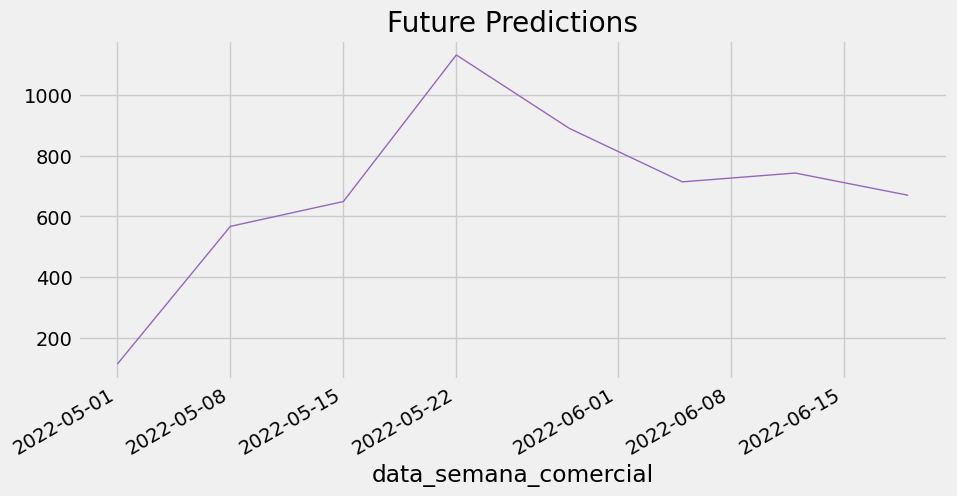

In [68]:
loja1_test['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

<AxesSubplot: title={'center': 'Future Predictions'}, xlabel='data_semana_comercial'>

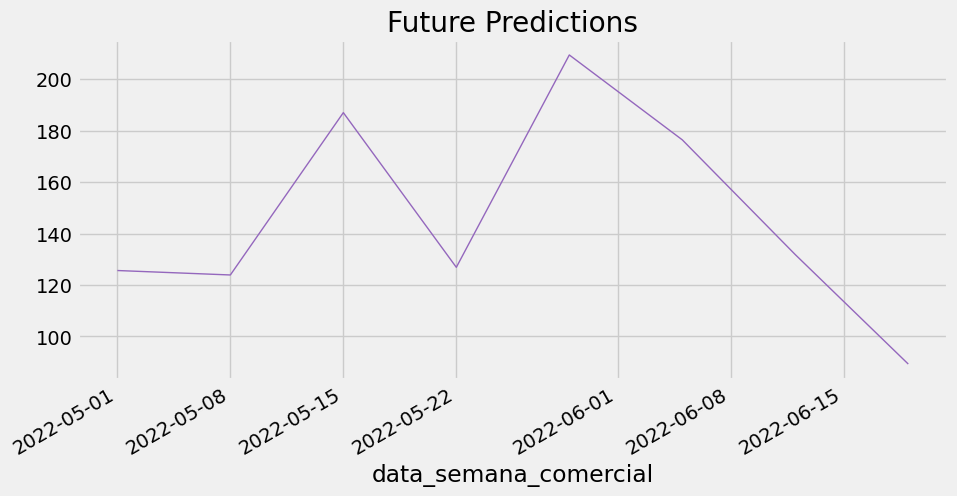

In [81]:
loja2_test['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')

In [96]:
loja1_test['APE'] = abs(loja1_test['pred'] - loja1_test['venda']) / loja1_test['venda'] * 100

In [97]:
loja2_test['APE'] = abs(loja2_test['pred'] - loja2_test['venda']) / loja2_test['venda'] * 100

In [ ]:
loja1_test['MAPE'] = mean_absolute_percentage_error(loja1_test['venda'], loja1_test['pred'])

In [ ]:
loja2_test['MAPE'] = mean_absolute_percentage_error(loja2_test['venda'], loja2_test['pred'])

In [98]:
loja1_test.head()

,venda,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,pred,MAPE,APE
data_semana_comercial,,,,,,,,,,,,,,
2022-05-15,1269,6,2,5,2022,135,15,19,605.0,572.0,NaN,648.787109,0.276377,48.874144
2022-05-08,605,6,2,5,2022,128,8,18,572.0,NaN,NaN,567.027527,0.276377,6.276442
2022-05-29,737,6,2,5,2022,149,29,21,1138.0,1269.0,605.0,889.725037,0.276377,20.722529
2022-05-01,572,6,2,5,2022,121,1,17,NaN,NaN,NaN,113.569244,0.276377,80.145237
2022-06-19,489,6,2,6,2022,170,19,24,644.0,814.0,737.0,669.282349,0.276377,36.867556


In [93]:
loja2_test.tail()

,cod_loja,venda,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,pred,MAPE
data_semana_comercial,,,,,,,,,,,,,,
2022-05-01,407,150,6,2,5,2022,121,1,17,NaN,NaN,NaN,125.616493,0.159226
2022-05-29,407,266,6,2,5,2022,149,29,21,107.0,246.0,202.0,209.402313,0.159226
2022-05-08,407,202,6,2,5,2022,128,8,18,150.0,NaN,NaN,123.884697,0.159226
2022-05-22,407,107,6,2,5,2022,142,22,20,246.0,202.0,150.0,126.856789,0.159226
2022-06-19,407,89,6,2,6,2022,170,19,24,129.0,188.0,266.0,89.260246,0.159226


In [3]:
def dataPipeline(dataframe):
    """
        Args:
            dataframe: Pandas dataframe com os dados de vendas
        Return:
            df_web: dataframe com os dados necessários para previsão das lojas web
            df_fisica: dataframe com os dados necessários para previsão das lojas fisicas
        OBS:
            Para previsão de séries temporais, após chamar o metodo e receber os novos dataframes, é preciso transformar
            a coluna 'data_semana_comercial' em datetime novamente e coloca-lá como index do df.
        OBS2:
            Se precisar usar os dias da semana, mes ou ano, basta usar os atributos do index após transformá-lo
    """
    df_pipe = dataframe.copy()
    print('Dataframe carregado!')

    #Dropando colunas desnecessárias
    df_pipe.drop(['item', 'semana_comercial'], axis=1, inplace=True)
    print("Colunas 'item' e 'semana_comercial' dropadas!")

    #Dropando linhas com vendas Guide Shop ('GS')
    df_pipe = df_pipe.loc[df_pipe['clima'] != 'GS']
    print('Vendas Guide Shop (GS) dropadas!')

    #Alterando vendas negativas para zero
    df_pipe.loc[df_pipe.venda < 0, 'venda'] = 0
    print('Vendas negativas alteradas para zero!')

    #Transformando variaveis categóricas em variaveis numéricas
    df_pipe['localidade'] = df_pipe['localidade'].map({ 'br':2, 'uy':1, 'ar':0 })
    df_pipe['loja_tamanho'] = df_pipe['loja_tamanho'].map({ 'PP':0, 'P':1, 'M':2, 'G':3, 'GG':4 })
    df_pipe['clima'] = df_pipe['clima'].map({ 'SPO':5, 'RIO':4, 'NOR':3, 'SUL':2 ,'URU':1 ,'ARG': 0, 'W':'W'})
    print('Variaveis categoricas transformadas em numéricas!')

    #Transformando a coluna 'data_semana_comercial' em datetime
    df_pipe.data_semana_comercial = pd.to_datetime(df_pipe.data_semana_comercial)
    print("coluna 'data_semana_comercial' transformada em datetime!")

    #Tratando dataset para lojas web
    df_web = df_pipe[df_pipe['categoria_loja'] == 'web']
    del df_web['categoria_loja']
    del df_web['clima']
    del df_web['localidade']
    del df_web['loja_tamanho']
    print('Dataset de treino para lojas web criado')
    

    #Tratando dataset para lojas web
    df_fisica = df_pipe[df_pipe['categoria_loja'] == 'fisica']
    del df_fisica['categoria_loja']
    print('Dataset de treino para lojas fisicas criado')
    
    return df_web, df_fisica